In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import re

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
class cfg:
    Q_TKN = "<usr>"
    A_TKN = "<sys>"
    BOS = '<s>'
    EOS = '</s>'
    MASK = '<unused0>'
    PAD = '<pad>'
    max_len = 256
    max_turns = 8
    epochs = 5
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    learning_rate = 1e-4

from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel

tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
            bos_token=cfg.BOS, eos_token=cfg.EOS, unk_token='<unk>',
            pad_token=cfg.PAD, mask_token=cfg.MASK)
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [3]:
# 데이터셋
# 전처리 후, 텀을 나눠놓은 상태의 데이터를 입력으로 받음
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from tqdm import tqdm
from itertools import chain

import copy

class CustomDataset(Dataset):
    """
        입력 : 전처리 후 대화 분리까지 완료된 데이터
            ex) ["밥 먹었어?", "응 밥 먹었어", "뭐 먹었어?", "샌드위치 먹었어"]
        출력 : 패딩까지 완료된 input_ids, token_type_ids, labels
    """
    def __init__(self, data, tokenizer, cfg):
        self.data = data
        self.Q_TKN = cfg.Q_TKN
        self.A_TKN = cfg.A_TKN
        self.BOS = cfg.BOS
        self.EOS = cfg.EOS
        self.MASK = cfg.MASK
        self.PAD = cfg.PAD
        self.max_len = cfg.max_len
        self.max_turns = cfg.max_turns
        
        self.input_ids = []
        self.token_type_ids = []
        self.labels = []
        
        for i in tqdm(range(len(self.data))):
            hists = []
            dials = self.data[i]
            
            for u, utter in enumerate(dials):
                if u % 2 == 0:
                    hists.append(self.Q_TKN + utter)  # Speaker 1: User
                else:
                    hists.append(self.A_TKN + utter)  # Speaker 2: System
            
            max_turn = max(len(hists), self.max_turns) # max_turns을 넘으면 post
            if max_turn % 2 != 0: max_turn -= 1 # user 대화로 끝남 방지
                
            for f in range(max_turn, 1, -2):
                contexts = hists[:f]
                if sum([len(l) for l in contexts]) > self.max_len-2: continue # BOS와 EOS 토큰을 추가하기 위해 -2
                contexts[0] = self.BOS + contexts[0]
                contexts[-1] = contexts[-1] + self.EOS
                contexts = [tokenizer.encode(ctx) for ctx in contexts]
                
                token_type_id = [[ctx[0]] * len(ctx) if c != 0 else [ctx[1]] * len(ctx) for c, ctx in enumerate(contexts)]
                label = [[-100] * len(ctx) if c != len(ctx) else ctx for c, ctx in enumerate(contexts)]
                
                input_id = list(chain.from_iterable(contexts))
                token_type_id = list(chain.from_iterable(token_type_id))
                label = list(chain.from_iterable(label))
                
                assert len(input_id) == len(token_type_id) == len(label), "There is something wrong in dialogue process."
                
                input_id, token_type_id, label = self.make_padding(input_id, token_type_id, label)
                
                self.input_ids.append(input_id)
                self.token_type_ids.append(token_type_id)
                self.labels.append(label)
                
                break
    
    def make_padding(self, input_id, token_type_id, label):
        left = self.max_len - len(input_id)
        
        input_id += [tokenizer.pad_token_id] * left
        token_type_id += [tokenizer.pad_token_id] * left
        label += [-100] * left
        
        return input_id, token_type_id, label
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.token_type_ids[idx], self.labels[idx]

In [4]:
Chatbot_Data = pd.read_csv('./data/multi_turn_tokens.csv')
# Test 용으로 300개 데이터만 처리한다.
Chatbot_Data = Chatbot_Data[:1000]
Chatbot_Data

,conversation
0,<user>우리 기간 언제까지나고 물어볼 수 없어 재등록 할 줄 알면 어케?<bot...
1,<user>아침<bot>헉<user>잘안먹구<bot>일찍 인나짜나<user>좀잇으면...
2,<user>18년도 잘한 일임니다<bot>넘나 레전급여행 개고생이었지만 뿌듯하네욘<...
3,<user>나왔당 ㅋ 내일은 폭풍야근 예상이지만ㅋㅋㅋ<bot>잉? 늦느줄알고 암것도...
4,<user>어디 괜차는사람업나 갑분이가<bot>훔 니 ?<user>그래 니가남자가 ...
...,...
995,<user>커플템은 그냥 케이스 같은거 일러스트로 된거 구런걸로 할까해..<bot>...
996,<user>졸려ㅠㅠ<bot>사주현도 졸리다<user>바로 잘 수 있지!! 사주현는 ...
997,<user>뭔가 어제부터 오늘아침까지 빈속테 매운거넉어서그렁가 배가 계속아파<bot...
998,<user>지갑 찾았어요??<bot>옹옹. 차에있더라구<user>거봐 내가 차에 있...


In [5]:
def token_split(sentence):
    sentence = re.sub(r"<user>", f" {cfg.Q_TKN} ", sentence)
    sentence = re.sub(r"<bot>", f" {cfg.A_TKN} ", sentence)
    sentence = sentence.split()
    ids = [i for i, word in enumerate(sentence) if word == cfg.Q_TKN or word == cfg.A_TKN]
    dials = [' '.join(sentence[ids[i]+1:ids[i+1]]) for i in range(len(ids)-1)] # ids[i]+1 : 토큰 포함, ids[i] : 토큰 미포함
    dials = [i for i in dials if i.strip() != ""]
    
    return dials

print(Chatbot_Data['conversation'][0])
print()
print(token_split(Chatbot_Data['conversation'][0]))

<user>우리 기간 언제까지나고 물어볼 수 없어 재등록 할 줄 알면 어케?<bot>헉.. 어떻게말해야되지?<user>그냥 자연스레.. 안나오면되비 아저씨가 먼저 말하려나? 연장할거냐고..하면 뭐랗9?<bot>고민해볼게요..? 생각해보고나올게요..? 대본짜줘..<user>다음 달은 바빠서 어려울 것 같고 다음번에 다시 올게요 어떠니??<bot>오 역시말을잘하네 너가말해!<user>참내 너 방은철같아<bot>부끄러워..<user>

['우리 기간 언제까지나고 물어볼 수 없어 재등록 할 줄 알면 어케?', '헉.. 어떻게말해야되지?', '그냥 자연스레.. 안나오면되비 아저씨가 먼저 말하려나? 연장할거냐고..하면 뭐랗9?', '고민해볼게요..? 생각해보고나올게요..? 대본짜줘..', '다음 달은 바빠서 어려울 것 같고 다음번에 다시 올게요 어떠니??', '오 역시말을잘하네 너가말해!', '참내 너 방은철같아', '부끄러워..']


In [6]:
Chatbot_Data['conversation'] = Chatbot_Data['conversation'].apply(token_split)

Chatbot_Data

,conversation
0,"[우리 기간 언제까지나고 물어볼 수 없어 재등록 할 줄 알면 어케?, 헉.. 어떻게..."
1,"[아침, 헉, 잘안먹구, 일찍 인나짜나, 좀잇으면 점심타임, 허어억 그럼 아점 땡겨야대]"
2,"[18년도 잘한 일임니다, 넘나 레전급여행 개고생이었지만 뿌듯하네욘, 저염, 가을 ..."
3,"[나왔당 ㅋ 내일은 폭풍야근 예상이지만ㅋㅋㅋ, 잉? 늦느줄알고 암것도안했는데 애들도..."
4,"[어디 괜차는사람업나 갑분이가, 훔 니 ?, 그래 니가남자가 어딧노 내가한재현씨잇을..."
...,...
995,"[커플템은 그냥 케이스 같은거 일러스트로 된거 구런걸로 할까해.., 오오 귀엽다잉!..."
996,"[졸려ㅠㅠ, 사주현도 졸리다, 바로 잘 수 있지!! 사주현는 못자지!!!!!!! 졸..."
997,"[뭔가 어제부터 오늘아침까지 빈속테 매운거넉어서그렁가 배가 계속아파, ㅠㅠ아안돼ㅠㅠ..."
998,"[지갑 찾았어요??, 옹옹. 차에있더라구, 거봐 내가 차에 있을거랬지 오빠의 행동반..."


In [7]:
def collate_batch(batch):
    data = [item[0] for item in batch]
    mask = [item[1] for item in batch]
    label = [item[2] for item in batch]
    return torch.LongTensor(data), torch.LongTensor(mask), torch.LongTensor(label)

#윈도우 환경에서 num_workers 는 무조건 0으로 지정, 리눅스에서는 2
train_set = CustomDataset(Chatbot_Data['conversation'], tokenizer, cfg)
train_dataloader = DataLoader(train_set, batch_size=8, num_workers=2, shuffle=True, collate_fn=collate_batch,)

100%|██████████| 1000/1000 [00:00<00:00, 1289.92it/s]


In [8]:
print("start")
for batch_idx, samples in enumerate(train_dataloader):
    if batch_idx > 5:
        break
    token_ids, mask, label = samples
    print("token_ids ====> ", token_ids)
    print("mask =====> ", mask)
    print("label =====> ", label)
print("end")

start
token_ids ====>  tensor([[    0,     2, 39201,  ...,     3,     3,     3],
        [    0,     2,  9235,  ...,     3,     3,     3],
        [    0,     2,  9063,  ...,     3,     3,     3],
        ...,
        [    0,     2, 18767,  ...,     3,     3,     3],
        [    0,     2, 10070,  ...,     3,     3,     3],
        [    0,     2, 10099,  ...,     3,     3,     3]])
mask =====>  tensor([[2, 2, 2,  ..., 3, 3, 3],
        [2, 2, 2,  ..., 3, 3, 3],
        [2, 2, 2,  ..., 3, 3, 3],
        ...,
        [2, 2, 2,  ..., 3, 3, 3],
        [2, 2, 2,  ..., 3, 3, 3],
        [2, 2, 2,  ..., 3, 3, 3]])
label =====>  tensor([[-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        ...,
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100]])
token_ids ====>  tensor([[    0,     2,  925

In [9]:
class ChatBot:
    losses = []
    
    def __init__(self, model, dataloader, tokenizer, cfg):
        """
            Args : model, dataloader, tokenizer, cfg
        """
        ChatBot.model = model
        ChatBot.dataloader = dataloader
        ChatBot.tokenizer = tokenizer
        ChatBot.device = cfg.device
        ChatBot.optim = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate)
        
        ChatBot.user_token_id = tokenizer.get_vocab()[cfg.Q_TKN]
        ChatBot.bot_token_id = tokenizer.get_vocab()[cfg.A_TKN]
        ChatBot.max_len = cfg.max_len
        ChatBot.max_turns = cfg.max_turns
    
    @classmethod
    def train(cls, epochs, save=None):
        """
            save : 모델을 저장할 경로
        """
        cls.model.to(cls.device)
        for epoch in range(epochs):
            cls.model.train()
            print(f"\n Epoch {epoch+1}/{epochs}", sep="\n")
            starttime = time.time()
            batch_loss = []

            for i, batch in enumerate(cls.dataloader):
                input_ids, token_type_ids, labels = batch
                input_ids, token_type_ids, labels = \
                    input_ids.to(cls.device), token_type_ids.to(cls.device), labels.to(cls.device)
                
                outputs = cls.model(
                    input_ids=input_ids,
                    token_type_ids = token_type_ids,
                    labels = labels
                )
                
                loss, logits = outputs[0], outputs[1]
                
                cls.optim.zero_grad()
                loss.backward()
                cls.optim.step()

                batch_loss.append(loss.item())
                
                print(cls.status(cls, i+1, time.time()-starttime, np.mean(batch_loss)), end='\r')

            cls.losses.append(np.mean(batch_loss))
            
            if save:
                PATH = f'{save}_epochs-{epoch+1}_loss-{np.mean(batch_loss)}.pth'
                torch.save(model.state_dict(), PATH)
    
    def status(self, step, time, loss):
        return "step : %d/%d - %ds | loss : %.6f | %.2fit/s"%(
            step,
            len(self.dataloader),
            int(time),
            loss,
            step/time
        )
    
    @classmethod
    def load_model(cls, PATH):
        """
            PATH : pth 파일이 저장된 경로
        """
        cls.model.load_state_dict(torch.load(PATH))
        print("model loaded.")
    
    @classmethod
    def talk(cls):
        print("Escape ment : quit")
        with torch.no_grad():
            cur_speaker = 1
            input_ids_list = []
            token_type_ids_list = []
            t = 0
            output_id = None

            while True:
                if cur_speaker == 1:
                    cur_speaker_id = cls.user_token_id
                    utter = input("You: ")

                    if utter == "quit":
                        print("Bot: Good bye.")
                        break

                    input_id = [cur_speaker_id] + cls.tokenizer.encode(utter)

                    if t == 0:
                        input_id = [cls.tokenizer.bos_token_id] + input_id
                else:
                    cur_speaker_id = cls.bot_token_id
                    input_id = copy.deepcopy(output_id)

                token_type_id = [cur_speaker_id] * len(input_id)

                if input_id[-1] == cls.tokenizer.eos_token_id:
                    input_id = input_id[:-1]
                    token_type_id = token_type_id[:-1] 

                input_ids_list.append(input_id)
                token_type_ids_list.append(token_type_id)

                if t >= cls.max_turns:
                    input_ids_list = input_ids_list[1:]
                    token_type_ids_list = token_type_ids_list[1:]

                next_speaker = (cur_speaker % 2) + 1
                if next_speaker == 1:
                    next_speaker_id = cls.user_token_id
                else:
                    next_speaker_id = cls.bot_token_id

                if cur_speaker == 1:
                    output_id = cls.nucleus_sampling(cls, input_ids_list, token_type_ids_list, next_speaker_id)
                    res = cls.tokenizer.decode(output_id)

                    print(f"Bot: {res}")

                cur_speaker = copy.deepcopy(next_speaker)
                t += 1

    def nucleus_sampling(self, input_ids_list, token_type_ids_list, next_speaker_id):
        output_id = []
        res_id = [next_speaker_id]
        res_type_id = [next_speaker_id]
        for pos in range(self.max_len):
            input_ids = list(chain.from_iterable(input_ids_list)) + res_id
            token_type_ids = list(chain.from_iterable(token_type_ids_list)) + res_type_id
            input_len = len(input_ids)

            left = self.max_len - len(input_ids)
            input_ids += [self.tokenizer.pad_token_id] * left
            token_type_ids += [self.tokenizer.pad_token_id] * left

            assert len(input_ids) == len(token_type_ids), "There is something wrong in dialogue process."

            input_ids = torch.LongTensor(input_ids).unsqueeze(0).to(self.device)  # (1, L)
            token_type_ids = torch.LongTensor(token_type_ids).unsqueeze(0).to(self.device)  # (1, L)

            output = self.model(input_ids=input_ids, token_type_ids=token_type_ids)[0][:, input_len-1]  # (1, vocab_size)
            output = F.softmax(output, dim=-1)  # (1, vocab_size)

            sorted_probs, sorted_idxs = torch.sort(output, descending=True)
            cumsum_probs = torch.cumsum(sorted_probs, dim=-1)  # (1, vocab_size)
            idx_remove = cumsum_probs > 0.9
            sorted_probs[idx_remove] = 1e-8
            sorted_probs /= torch.sum(sorted_probs, dim=-1, keepdim=True)  # (1, vocab_size)

            # Random sampling
            probs = torch.zeros(output.shape).to(self.device).scatter_(-1, sorted_idxs, sorted_probs)  # (1, vocab_size)
            idx = torch.multinomial(probs, 1).squeeze(-1).squeeze(0).item()

            if len(output_id) == self.max_len or idx == self.tokenizer.eos_token_id:
                break
            else:
                output_id.append(idx)
                res_id.append(idx)
                res_type_id.append(next_speaker_id)

        return output_id

In [10]:
prototype = ChatBot(model, train_dataloader, tokenizer, cfg)

In [11]:
prototype.train(cfg.epochs, save='./skt-kogpt2_1000')


 Epoch 1/5
step : 125/125 - 65s | loss : 4.769154 | 1.91it/s
 Epoch 2/5
step : 125/125 - 64s | loss : 3.240867 | 1.93it/s
 Epoch 3/5
step : 125/125 - 65s | loss : 2.617334 | 1.92it/s
 Epoch 4/5
step : 125/125 - 65s | loss : 2.102897 | 1.92it/s
 Epoch 5/5


In [12]:
prototype.talk()

Escape ment : quit
You: 카페갈래?
Bot: ㅠㅠᄏᄏᄏᄏᄏᄏᄏᄏ丑<usr> 웅<usr> 음제<usr> 바로 떠올랏네<usr> 두세 유전자가 없지..<usr> ᄏ 나간다.
 서울대인가..<usr>ᄏ 식품가 저..<usr> 돌아돌아<unk> 정부도시 이미지인데..ᄏ 들어가는.<usr> 맞아..ᄏ 자격을 좋지....ᄏ 200년 바로 떠올..ᄏᄏ개인. 교육이라栻  1종 아직 수치인데..ᄏ 데려..<sys> 기준 지금..ᄏᄏ첨의..
You: 싫으면 말고
Bot: 뭐 뭐 그렇..
You: quit
Bot: Good bye.


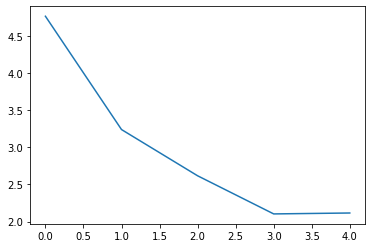

In [17]:
plt.plot(prototype.losses)
plt.show()

In [14]:
path = './chatbot_multi-turn_340000_6.pth'
prototype.load_model(path)

In [15]:
prototype.talk()

Escape ment : quit
You: 카페갈래?
Bot: 결제했다
You: 뭐 샀는데?
Bot: 제넥합
You: 뭐야 그건 처음 들어봐
Bot: 아직 품레인다 가지고 나와있길 휴양ᄒ
You: 뭐라는거야 자꾸
Bot: 하루에욜저녁대여
You: 그래 알았어 좀만 더 학습하자
Bot: 엉 너무 추워요
You: quit
Bot: Good bye.
